In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

In [65]:
'''
Implementing the iterative pagerank algorithm
'''

# distribution_vecor E is the pr distribution of ranks of web pages that users jump to when they get bored after successive links at ranodm
def build_transition_matrix(G, distribution_vector=None):
    """
    Absorbing pages: (dead) Pages which have an incoming link, but no outgoing link (AKA Dangling links). 
    In this case, we assume that if random surfer happens to land at such a page(node), they can teleport to any of the nodes with equal probability. This helps the algorithm to converge

    """
    num_pages = len(G.nodes())

    # building standard distribution_vector E if none provided 
    if distribution_vector is None:
        # all entries of random_surf = 1/T
        distribution_vector = np.ones(shape = (num_pages, )) /num_pages

    # distribution_vector is provided by not appropraite
    elif len(distribution_vector) != num_pages:
        print(f"Distribution Vector has incorrect dimensions!\nShape of distribution_vector = {distribution_vector.shape}\nShape of Transition Matrix = {transition_matrix.shape}")
        exit()

    # building adjacent matrix from graph
    # '1' and '0' represent the presence or absence of a link between any two pages
    adj_matrix = np.zeros(shape=(num_pages, num_pages))
    for link in G.edges():
        adj_matrix[link[0]-1, link[1]-1] = 1 # -1 since nodes index starts from 1
    # print(adj_matrix)

    # building transition matrix
    # entries value: 1/T
    transition_matrix = adj_matrix/np.sum(adj_matrix, axis=1).reshape(-1,1)
    # print(transition_matrix)
    
    # building stochastic transition matrix for absorbing pages, ie nodes with col that are all 0
    absorbing_pages = np.zeros(num_pages) 
    for page in G.nodes():
        # Check for any dead nodes
        if len(G.out_edges(page))==0:
            absorbing_pages[page-1] = 1 # -1 since nodes index starts from 1
    # print(absorbing_pages)
    absorbing_pages_matrix = np.outer(absorbing_pages, np.ones(shape = (num_pages,))) / num_pages
    # print(absorbing_pages_matrix)
    
    # stochastic matrix
    stochastic_matrix = transition_matrix + absorbing_pages_matrix
    # print(stochastic_matrix)
    
    return np.transpose(stochastic_matrix), distribution_vector


def pagerank(G, teleport_pr, initial_pagerank=None, distribution_vector=None, max_iterations=100, tolerance=1.0e-6):
    """
    Teleportation probability: Probability that a random surfer no longer wants to keep following hyperlinks, but restarts the search process. 
    """
    num_pages = len(G.nodes())

    # Initializing initial pagerank, R0
    if initial_pagerank is None:
        initial_pagerank = np.ones(num_pages) / num_pages
    elif len(initial_pagerank) != num_pages:
        print(f"Initial Pagerank Vector has incorrect dimensions!\nShape of initial_pagerank = {initial_pagerank.shape}\nShape of Transition Matrix = ({num_pages}, {num_pages})")
        exit()
    pagerank = initial_pagerank

    # Building transition matrix M
    pagerank_matrix, distribution_vector = build_transition_matrix(G, distribution_vector)
    # print(pagerank_matrix)

    # Keep track of L1 norm between pageranks of successive iterations
    norm_history = []
    #Keep track of pagerank histories
    pagerank_history = []
    pagerank_history.append(pagerank)
    
    # Iterate until convergence
    for i in range(max_iterations):
        # Formula
        new_pagerank = (1 - teleport_pr) * np.dot(pagerank_matrix, pagerank) + teleport_pr * distribution_vector

        # accumulate norm
        norm = np.linalg.norm(new_pagerank - pagerank, 1)
        norm_history.append(norm)

        # check for convergence
        if norm < tolerance:
            break

        pagerank = new_pagerank
        pagerank_history.append(pagerank)
    
    print_statistics(G, teleport_pr, initial_pagerank, distribution_vector, max_iterations, tolerance, pagerank_matrix, pagerank, i, norm_history, pagerank_history)
    return pagerank

def calc_closed_form():


def print_statistics(G, teleport_pr, initial_pagerank, distribution_vector, max_iterations, tolerance, pagerank_matrix, final_pagerank, iteration, norm_history, pagerank_history):
    # Print example definitions
    print(f"\nProblem definition..")
    print("Number of pages: ", len(G.nodes()))
    print("Number of links: ", len(G.edges()))
    print(f"\nInitial Pagerank: ", initial_pagerank)
    print("Distribution Vector: ", distribution_vector)
    print("Teleportation Probability: ", teleport_pr)
    print(f"\nmax_iterations: ", max_iterations)
    print(f"tolerance: ", tolerance)

    # Print intermediate results
    print(f"\nPagerank Matrix..\n" , pagerank_matrix)

    # Print Results
    print(f"\n=======================Results=======================")
    print("PageRank..")
    print(final_pagerank)
    print(f"\nConverged at {iteration+1} iterations..")
    for i in range(iteration):
        print(f"iteration {i}: ", pagerank_history[iteration])
    # Display Convergence Plot
    plt.figure(figsize=(5,4))
    plt.plot(range(iteration+1), norm_history)
    plt.xlabel('iterations')
    plt.ylabel('Euclidean Norm')
    plt.title('Convergence plot')
    plt.show()


In [ ]:
def pagerank_numpy(G, alpha=0.85):
    """Returns the PageRank of the nodes in the graph.

    PageRank computes a ranking of the nodes in the graph G based on
    the structure of the incoming links. It was originally designed as
    an algorithm to rank web pages.

    Parameters
    ----------
    G : graph
      A NetworkX graph.  Undirected graphs will be converted to a directed
      graph with two directed edges for each undirected edge.

    alpha : float, optional
      Damping parameter for PageRank, default=0.85.

    Returns
    -------
    pagerank : dictionary
       Dictionary of nodes with PageRank as value.

    Examples
    --------
    >>> G = nx.DiGraph(nx.path_graph(4))
    >>> pr = nx.pagerank_numpy(G, alpha=0.9)

    Notes
    -----
    The eigenvector calculation uses NumPy's interface to the LAPACK
    eigenvalue solvers.  This will be the fastest and most accurate
    for small graphs.

    References
    ----------
    .. [1] A. Langville and C. Meyer,
       "A survey of eigenvector methods of web information retrieval."
       http://citeseer.ist.psu.edu/713792.html
    .. [2] Page, Lawrence; Brin, Sergey; Motwani, Rajeev and Winograd, Terry,
       The PageRank citation ranking: Bringing order to the Web. 1999
       http://dbpubs.stanford.edu:8090/pub/showDoc.Fulltext?lang=en&doc=1999-66&format=pdf
    """
    if len(G) == 0:
        return {}
    M = google_matrix(G, alpha)
    
    # use numpy LAPACK solver
    eigenvalues, eigenvectors = np.linalg.eig(M.T)
    ind = np.argmax(eigenvalues)

    # eigenvector of largest eigenvalue is at ind, normalized
    largest = np.array(eigenvectors[:, ind]).flatten().real
    norm = float(largest.sum())
    return dict(zip(G, map(float, largest / norm)))

# Experiments

## Four-webpages on Slife 53 of Lecture 7

# Standard initia........

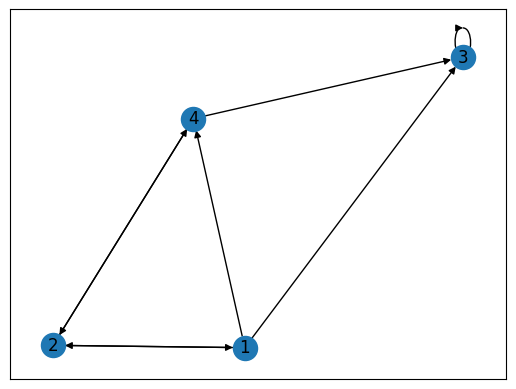

In [67]:
# 4 web-pages example in Lecture slides 53
g1 = nx.DiGraph()
g1.add_edges_from([(1,2), (1,3), (1,4),
                   (2,1), (2,4),
                   (3,3),
                   (4,2), (4,3)])
nx.draw_networkx(g1)

pagerank: 

Problem definition..
Number of pages:  4
Number of links:  8

Initial Pagerank:  [0.25 0.25 0.25 0.25]
Distribution Vector:  [0.25 0.25 0.25 0.25]
Teleportation Probability:  0.2

max_iterations:  100
tolerance:  1e-06

Pagerank Matrix..
 [[0.    0.5   0.    0.   ]
 [0.333 0.    0.    0.5  ]
 [0.333 0.    1.    0.5  ]
 [0.333 0.5   0.    0.   ]]

=======================Results=======================
PageRank..
[0.101 0.128 0.642 0.128]

Converged at 25 iterations..
iteration 0:  [0.101 0.128 0.642 0.128]
iteration 1:  [0.101 0.128 0.642 0.128]
iteration 2:  [0.101 0.128 0.642 0.128]
iteration 3:  [0.101 0.128 0.642 0.128]
iteration 4:  [0.101 0.128 0.642 0.128]
iteration 5:  [0.101 0.128 0.642 0.128]
iteration 6:  [0.101 0.128 0.642 0.128]
iteration 7:  [0.101 0.128 0.642 0.128]
iteration 8:  [0.101 0.128 0.642 0.128]
iteration 9:  [0.101 0.128 0.642 0.128]
iteration 10:  [0.101 0.128 0.642 0.128]
iteration 11:  [0.101 0.128 0.642 0.128]
iteration 12:  [0.101 0.128 0.642 0.

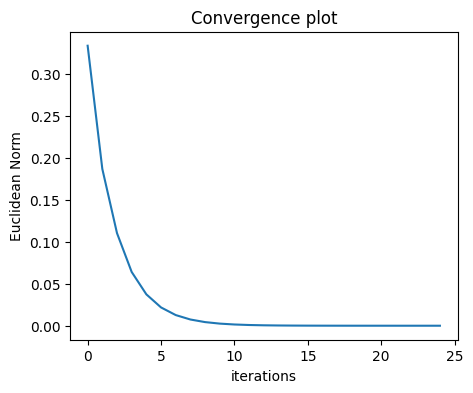

array([0.101, 0.128, 0.642, 0.128])

In [69]:
pagerank(g1, teleport_pr=0.2)

pagerank: 

Problem definition..
Number of pages:  3
Number of links:  5

Initial Pagerank:  [0.333 0.333 0.333]
Distribution Vector:  [0.333 0.333 0.333]
Teleportation Probability:  0.8

max_iterations:  100
tolerance:  1e-06

Pagerank Matrix..
 [[0.5 0.5 0. ]
 [0.5 0.  0. ]
 [0.  0.5 1. ]]

=======================Results=======================
PageRank..
[0.33  0.3   0.371]

Converged at 7 iterations..
iteration 0:  [0.33  0.3   0.371]
iteration 1:  [0.33  0.3   0.371]
iteration 2:  [0.33  0.3   0.371]
iteration 3:  [0.33  0.3   0.371]
iteration 4:  [0.33  0.3   0.371]
iteration 5:  [0.33  0.3   0.371]


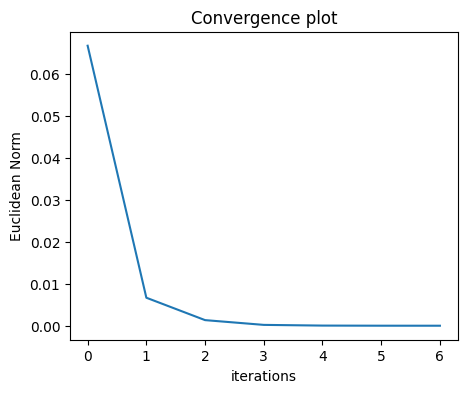

array([0.33 , 0.3  , 0.371])

In [66]:
# # Test
# G = nx.DiGraph()
# G.add_edges_from([(1, 1), (1, 2), (2, 1), (2, 3), (3, 3)])

# pagerank(G, teleport_pr=0.8)